In [9]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
# !pip install git+https://github.com/huggingface/transformers.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-f7e8gkm5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-f7e8gkm5

  Resolved https://github.com/huggingface/transformers.git to commit fc8764c9a618add64c33e83720f974750bcd0978
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10938856 sha256=edd30da2b12fc33f5b1ac7658e9e31ab44368ae6ac027e0d39d0a01bc71f5058
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kpch83v/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0


Reward : 0.4483201205730438


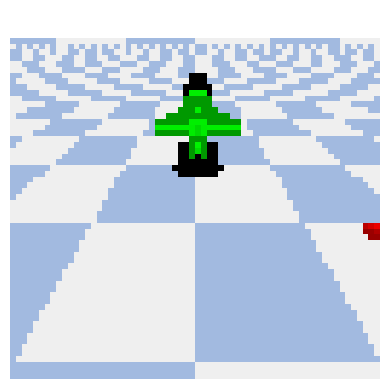

In [5]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

import rx150.rx150_env 
importlib.reload(rx150.rx150_env)

from rx150.rx150_env import RX150Env 

urdf_path = "/interbotix_ros_manipulators/interbotix_ros_xsarms/interbotix_xsarm_descriptions/urdf/rx150.urdf"

# print(urdf_path)

rx_env = RX150Env(urdf_path,headless=True,image_height=64,image_width=64)

rx_env.reset()

# action = np.random.choice([-1,0,1], size=5)
# action = np.append(action,np.random.choice([0,1],size=1))

# for _ in range(100):
#     rx_env.step(action)

rx_img = rx_env.render()

rw,_ = rx_env.get_reward_and_terminal()
print(f"Reward : {rw}")

rx_env.close()

plt.imshow(rx_img)
plt.axis("off")
plt.show()

In [11]:
import torch
from transformers import CLIPProcessor, CLIPModel,ChineseCLIPModel,ChineseCLIPProcessor

# Load CLIP model and processor
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# model = ChineseCLIPModel.from_pretrained("OFA-Sys/chinese-clip-vit-base-patch16")
# processor = ChineseCLIPProcessor.from_pretrained("OFA-Sys/chinese-clip-vit-base-patch16")

from transformers import AutoProcessor, AutoModel

# Load SpatialRGPT model and processor

# model_name = "a8cheng/SpatialRGPT-VILA1.5-8B"
# model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
# processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

model_name = "remyxai/SpaceLLaVA"

model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

ctxt_prompt = "A 3D model of a robot arm and a red dot with a green end-effector."

# Text descriptions
text_descriptions = [
    # ctxt_prompt + "The robot arm's green end effector is touching the red dot",
    # ctxt_prompt + "The robot arm's green end-effector is on the top part of the image",
    # ctxt_prompt + "The robot arm's green end-effector is on the bottom part of the image",
    # ctxt_prompt + "The robot arm's green end-effector is on the right part of the image",
    # ctxt_prompt + "The robot arm's green end-effector is on the left part of the image",
    # "A picture of a 3D humanoid kneeling down.",
    # "3D robot arm",
    # "3D model",
    # "3D simulation",
    # "an elephant jumping and down",
    ctxt_prompt + "The robot arm's green end effector is touching the red dot",
    ctxt_prompt + "The robot arm's green end effector is not at all touching the red dot",
    "The robot arm's green end effector is touching the red dot",
    "The robot arm's green end effector is not at all touching the red dot",
    ctxt_prompt + "The robot arm is extending to the left side",
    ctxt_prompt + "The robot arm is extending to the right side",
    ctxt_prompt + "The robot arm is extending to the top side",
    ctxt_prompt + "The robot arm is extending to the bottom side",
    "The robot arm is extending to the left side",
    "The robot arm is extending to the right side",
    "The robot arm is extending to the top side",
    "The robot arm is extending to the bottom side",
    "The green circle is touching the red dot",
    "The green circle is not at all touching the red dot",
]

ch_ctxt_prompt = "一个 3D 机器人手臂模型和一个红色点，其中机器人的绿色末端执行器。"

ch_text_descriptions = [
    ch_ctxt_prompt + " 机器人手臂的绿色末端执行器正在触碰红色点。",
    ch_ctxt_prompt + " 机器人手臂的绿色末端执行器完全没有触碰红色点。",
    "机器人手臂的绿色末端执行器正在触碰红色点。",
    "机器人手臂的绿色末端执行器完全没有触碰红色点。",
    ch_ctxt_prompt + " 机器人手臂正在向左侧伸展。",
    ch_ctxt_prompt + " 机器人手臂正在向右侧伸展。",
    ch_ctxt_prompt + " 机器人手臂正在向上方伸展。",
    ch_ctxt_prompt + " 机器人手臂正在向下方伸展。",
    "机器人手臂正在向左侧伸展。",
    "机器人手臂正在向右侧伸展。",
    "机器人手臂正在向上方伸展。",
    "机器人手臂正在向下方伸展。",
    "绿色圆形正在触碰红色点。",
    "绿色圆形完全没有触碰红色点。",
]

# Process inputs
# inputs = processor(text=ch_text_descriptions, images=rx_img, return_tensors="pt", padding=True)
inputs = processor(text=text_descriptions, images=rx_img, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # Image-text similarity score
probs = logits_per_image.softmax(dim=1) 

sorted_indices = torch.argsort(probs, descending=True)
sorted_probs = probs[0][sorted_indices]
sorted_desc = np.array(text_descriptions)[sorted_indices]

for desc,prob in zip(sorted_desc[0],sorted_probs[0].detach().numpy()):
    print(f"{desc} : {prob:.2f}")


# sim_inputs = processor(text=["A 3D model of a robot arm and a red dot with a green end-effector. The robot arm's green end effector is touching the red dot"], images=rx_img, return_tensors="pt", padding=True)

# # Compute text and image features
# with torch.no_grad():
#     text_features = model.get_text_features(**{k: sim_inputs[k] for k in ["input_ids", "attention_mask"]})
#     image_features = model.get_image_features(**{k: sim_inputs[k] for k in ["pixel_values"]})

# # Normalize features
# text_features = text_features / text_features.norm(dim=-1, keepdim=True)
# image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# # Compute similarity score
# similarity_score = (text_features @ image_features.T) 

# # Goal / Baseline text processing
# goal_prompt = "A 3D model of a robot arm and a red dot with a green end-effector. The robot arm's green end effector is not touching the red dot"
# baseline_prompt = "A 3D model of a robot arm and a red dot with a green end-effector."

# goal_text_input = processor(text=[goal_prompt], return_tensors="pt", padding=True)
# baseline_text_input = processor(text=[baseline_prompt], return_tensors="pt", padding=True)

# with torch.no_grad():
#     goal_text_features = model.get_text_features(**{k: goal_text_input[k] for k in ["input_ids", "attention_mask"]})
#     baseline_text_features = model.get_text_features(**{k: baseline_text_input[k] for k in ["input_ids", "attention_mask"]})

# # Normalize goal and baseline text features
# goal_norm_text_features = goal_text_features / goal_text_features.norm(dim=-1, keepdim=True)
# baseline_norm_text_features = baseline_text_features / baseline_text_features.norm(dim=-1, keepdim=True)

# goal_baseline_line = goal_norm_text_features - baseline_norm_text_features
# goal_baseline_norm_line = goal_baseline_line / goal_baseline_line.norm(dim=-1, keepdim=True)

# # Projection of image features onto the goal-baseline line
# proj_img = (goal_baseline_norm_line @ image_features.T) * goal_baseline_norm_line

# # Compute CLIP-Reg reward
# clip_reg_alpha = 0.5
# clip_reg = 1 - 0.5 * torch.sum(((clip_reg_alpha * proj_img + (1 - clip_reg_alpha) * image_features - goal_baseline_norm_line)) ** 2, dim=-1)

# # Print results
# print("Similarity Score:")
# print(similarity_score)
# print("\nLogits Per Image:")
# print(logits_per_image)
# print("\nProbs Per Image:")
# print(probs)
# print("\nCLIP-Reg:")
# print(clip_reg)


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

ValueError: Unrecognized configuration class <class 'transformers.models.llava.configuration_llava.LlavaConfig'> for this kind of AutoModel: AutoModel.
Model type should be one of AlbertConfig, AlignConfig, AltCLIPConfig, AriaConfig, AriaTextConfig, ASTConfig, AutoformerConfig, BambaConfig, BarkConfig, BartConfig, BeitConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitConfig, BlenderbotConfig, BlenderbotSmallConfig, BlipConfig, Blip2Config, BloomConfig, BridgeTowerConfig, BrosConfig, CamembertConfig, CanineConfig, ChameleonConfig, ChineseCLIPConfig, ChineseCLIPVisionConfig, ClapConfig, CLIPConfig, CLIPTextConfig, CLIPVisionConfig, CLIPSegConfig, ClvpConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, ConditionalDetrConfig, ConvBertConfig, ConvNextConfig, ConvNextV2Config, CpmAntConfig, CTRLConfig, CvtConfig, DabDetrConfig, DacConfig, Data2VecAudioConfig, Data2VecTextConfig, Data2VecVisionConfig, DbrxConfig, DebertaConfig, DebertaV2Config, DecisionTransformerConfig, DeformableDetrConfig, DeiTConfig, DepthProConfig, DetaConfig, DetrConfig, DiffLlamaConfig, DinatConfig, Dinov2Config, Dinov2WithRegistersConfig, DistilBertConfig, DonutSwinConfig, DPRConfig, DPTConfig, EfficientFormerConfig, EfficientNetConfig, ElectraConfig, EncodecConfig, ErnieConfig, ErnieMConfig, EsmConfig, FalconConfig, FalconMambaConfig, FastSpeech2ConformerConfig, FlaubertConfig, FlavaConfig, FNetConfig, FocalNetConfig, FSMTConfig, FunnelConfig, GemmaConfig, Gemma2Config, GitConfig, GlmConfig, GLPNConfig, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GPTJConfig, GPTSanJapaneseConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeSharedConfig, GraphormerConfig, GroundingDinoConfig, GroupViTConfig, HeliumConfig, HieraConfig, HubertConfig, IBertConfig, IdeficsConfig, Idefics2Config, Idefics3Config, Idefics3VisionConfig, IJepaConfig, ImageGPTConfig, InformerConfig, JambaConfig, JetMoeConfig, JukeboxConfig, Kosmos2Config, LayoutLMConfig, LayoutLMv2Config, LayoutLMv3Config, LEDConfig, LevitConfig, LiltConfig, LlamaConfig, LongformerConfig, LongT5Config, LukeConfig, LxmertConfig, M2M100Config, MambaConfig, Mamba2Config, MarianConfig, MarkupLMConfig, Mask2FormerConfig, MaskFormerConfig, MaskFormerSwinConfig, MBartConfig, MCTCTConfig, MegaConfig, MegatronBertConfig, MgpstrConfig, MimiConfig, MistralConfig, MixtralConfig, MobileBertConfig, MobileNetV1Config, MobileNetV2Config, MobileViTConfig, MobileViTV2Config, ModernBertConfig, MoonshineConfig, MoshiConfig, MPNetConfig, MptConfig, MraConfig, MT5Config, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NatConfig, NemotronConfig, NezhaConfig, NllbMoeConfig, NystromformerConfig, OlmoConfig, Olmo2Config, OlmoeConfig, OmDetTurboConfig, OneFormerConfig, OpenLlamaConfig, OpenAIGPTConfig, OPTConfig, Owlv2Config, OwlViTConfig, PatchTSMixerConfig, PatchTSTConfig, PegasusConfig, PegasusXConfig, PerceiverConfig, PersimmonConfig, PhiConfig, Phi3Config, PhimoeConfig, PixtralVisionConfig, PLBartConfig, PoolFormerConfig, ProphetNetConfig, PvtConfig, PvtV2Config, QDQBertConfig, Qwen2Config, Qwen2_5_VLConfig, Qwen2AudioEncoderConfig, Qwen2MoeConfig, Qwen2VLConfig, RecurrentGemmaConfig, ReformerConfig, RegNetConfig, RemBertConfig, ResNetConfig, RetriBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RTDetrConfig, RTDetrV2Config, RwkvConfig, SamConfig, SeamlessM4TConfig, SeamlessM4Tv2Config, SegformerConfig, SegGptConfig, SEWConfig, SEWDConfig, SiglipConfig, SiglipVisionConfig, Speech2TextConfig, SpeechT5Config, SplinterConfig, SqueezeBertConfig, StableLmConfig, Starcoder2Config, SuperGlueConfig, SwiftFormerConfig, SwinConfig, Swin2SRConfig, Swinv2Config, SwitchTransformersConfig, T5Config, TableTransformerConfig, TapasConfig, TextNetConfig, TimeSeriesTransformerConfig, TimesformerConfig, TimmBackboneConfig, TimmWrapperConfig, TrajectoryTransformerConfig, TransfoXLConfig, TvltConfig, TvpConfig, UdopConfig, UMT5Config, UniSpeechConfig, UniSpeechSatConfig, UnivNetConfig, VanConfig, VideoMAEConfig, ViltConfig, VisionTextDualEncoderConfig, VisualBertConfig, ViTConfig, ViTHybridConfig, ViTMAEConfig, ViTMSNConfig, VitDetConfig, VitsConfig, VivitConfig, Wav2Vec2Config, Wav2Vec2BertConfig, Wav2Vec2ConformerConfig, WavLMConfig, WhisperConfig, XCLIPConfig, XGLMConfig, XLMConfig, XLMProphetNetConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, XmodConfig, YolosConfig, YosoConfig, ZambaConfig, Zamba2Config.